# Read input log file into RDD object

In [1]:
import sys

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame, Row, Column, Window
from pyspark.sql import functions as func
from pyspark.sql.types import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import calendar

from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# jupyter notebook is configured with SparkContext instance
# Cannot create another instance, hence commenting the following
conf = SparkConf()
#sc = SparkContext(conf=conf)

# Create SparkSession (Entry point for pyspark Sql and DataFrame)
spark = SparkSession.builder.master("local").appName("Weblog").config(conf=conf).getOrCreate()

# Read input log file in spark context and create RDD object of input data
log_data = sc.textFile("data/2015_07_22_mktplace_shop_web_log_sample.log.gz")

# Print test output of the log file
str1 = log_data.take(1)
print(str1)

%matplotlib inline

[u'2015-07-22T09:00:28.019143Z marketpalce-shop 123.242.248.130:54635 10.0.6.158:80 0.000022 0.026109 0.00002 200 200 0 699 "GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36" ECDHE-RSA-AES128-GCM-SHA256 TLSv1.2']


In [2]:
# Extracts meaningful attributes from a line of the log file 
# and adds them to a pyspark sql Row object

def LineToRow(line):
    words = line.split(" ")

    # Convert time to TimeStamp format
    datetime_time = datetime.datetime.strptime(words[0], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    # Convert time to timestamp format
    timestamp = calendar.timegm(datetime_time.utctimetuple())                 
    
    # Extract IP and port of client
    client_ip, client_port = words[2].split(":")
    
    # Create Row object
    row = Row(timestamp = timestamp,           # Timestamp
              hour = datetime_time.hour,       # Hour from the timestamp
              minute = datetime_time.minute,   # Minute from the timestamp
              client_ip = client_ip, 
              url = words[12]) 
    
    return row

# Test the Row conversion method on first line of log file
print(LineToRow(str1[0]))


Row(client_ip=u'123.242.248.130', hour=9, minute=0, timestamp=1437555628, url=u'https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null')


In [3]:
# Define schema for the log DataFrame

schema = StructType([
        StructField("timestamp", LongType(), True),
        StructField("hour", IntegerType(), True),
        StructField("minute", IntegerType(), True),
        StructField("client_ip", StringType(), True),
        StructField("url", StringType(), True)])

In [4]:
# Map lines of log data to Row objects
row_log_data = log_data.map(lambda row: LineToRow(row))

# Create DataFrame from Row objects with the schema
log_df = spark.createDataFrame(row_log_data, schema)

# Create a Window Specification object for IP-wise operations on the data frame
window_spec = Window.partitionBy(log_df.client_ip).orderBy(log_df.timestamp)

# Add columns in the DataFrame for previous and next timestamp of a give IP
# If the prev or next time is not present, i.e. the current timestamp is either
# first or last respectively in the log file then the column value will be None
# Here we apply 'lag' and 'lead' fuctions repectively on the Window partitioned
# by IP address to get previous and next timestamps for the given IP
# The resultant DataFrame is ordered by the timestamp at the end
df_prev_next = log_df.withColumn('prev_timestamp', func.lag(log_df.timestamp, 1).over(window_spec))\
.withColumn('next_timestamp', func.lead(log_df.timestamp, 1).over(window_spec))\
.orderBy(log_df.timestamp)

In [5]:
# Add column for Time Since Prev Hit and Time Until Next Hit.
# Time Since Prev Hit is difference between current timestamp 
# and previous timestamp.
# Time Until Next Hit is difference between next timestamp and
# current timestamp.

df_prev_next = df_prev_next.withColumn('time_since_prev', df_prev_next.timestamp - df_prev_next.prev_timestamp)\
.withColumn('time_till_nxt', df_prev_next.next_timestamp - df_prev_next.timestamp)\
.orderBy(df_prev_next.timestamp)

In [6]:
# Now, select all the Rows which correspond to first or last
# or both first and last appearance of an IP in a session

# Assumption: If the user is inactive for more than 15 mins,
# then assume the session length to be 15 mins
MaxSessionTime = 900

### A user appears for the first time in a session if
##### 1. time_since_prev is None (In this case, this is  the first appearance of the user in the logs also), or
##### 2. time_since_prev is more than MaxSessionTime

### A user appears for the last time in a session if
##### 1. time_till_nxt is None (In this case this is the last appearance of the user in the logs also), or
##### 2. time_till_nxt is more than MaxSessionTime

### A user appears for the first as well as last time
##### in a session, i.e. the appearance is only appearance in that session if both of the following are True
##### 1. time_since_prev is either None or more than MaxSessionTime
##### 2. time_till_nxt is either None or more than MaxSessionTime

In [7]:
# Selecting rows for which time_since_prev and time_till_nxt 
# are more than 900 or null. Since only these rows correspond to
# first and last appearance of an IP in a session
df_prev_next = df_prev_next.filter(func.isnull(df_prev_next.time_since_prev) | (df_prev_next.time_since_prev > MaxSessionTime) |\
                       (func.isnull(df_prev_next.time_till_nxt)) | (df_prev_next.time_till_nxt > MaxSessionTime))\
                        .orderBy(df_prev_next.timestamp)

# Conditions for adding a column in the DataFrame, which indicates
# if a session request is first or last or only appearance in the DataFrama

col_filter = func\
    .when((func.isnull('time_since_prev') & func.isnull('time_till_nxt')), 'FirstAndLast')\
    .when((func.isnull('time_since_prev') & (df_prev_next.time_till_nxt > MaxSessionTime)), 'FirstAndLast')\
    .when((func.isnull('time_since_prev') & (df_prev_next.time_till_nxt < MaxSessionTime)), 'First')\
    .when(((df_prev_next.time_since_prev > MaxSessionTime) & func.isnull('time_till_nxt')), 'FirstAndLast')\
    .when(((df_prev_next.time_since_prev > MaxSessionTime) & (df_prev_next.time_till_nxt < MaxSessionTime)), 'First')\
    .when(((df_prev_next.time_since_prev > MaxSessionTime) & (df_prev_next.time_till_nxt > MaxSessionTime)), 'FirstAndLast')\
    .when(((df_prev_next.time_since_prev < MaxSessionTime) & func.isnull('time_till_nxt')), 'Last')\
    .when(((df_prev_next.time_since_prev < MaxSessionTime) & (df_prev_next.time_till_nxt > MaxSessionTime)), 'Last')
    
# Apply the above condition on DataFrame and create a column visit_type
df_prev_next = df_prev_next.withColumn('visit_type', col_filter)

## Computing Sesssion Time

##### If visit_type is "First", then there must be a visit_type "Last" in the next column for a user. In this case Session Time is difference of timestamps of these two columns

##### If the visit_type is "FirstAndLast", then the SessionTime is 15 mins (with MaxSessionTime assumption)

In [8]:
# Create a Window Specification object for IP-wise operations on the data frame
window_spec = Window.partitionBy(df_prev_next.client_ip).orderBy(df_prev_next.timestamp)

df_prev_next = df_prev_next.withColumn('session_time', df_prev_next.next_timestamp - df_prev_next.timestamp)
df_prev_next = df_prev_next.filter(df_prev_next.visit_type != 'Last')

df_prev_next = df_prev_next\
.withColumn('session_time_new',func.when(df_prev_next.visit_type != 'FirstAndLast', df_prev_next.session_time).otherwise(MaxSessionTime))\
.drop(df_prev_next.session_time)


# 1.1 Arrange columns to create sessionization DataFrame

In [9]:
sessionized_df = df_prev_next.withColumnRenamed('timestamp','start_time')\
                 .withColumnRenamed('next_timestamp', 'end_time')\
                 .withColumnRenamed('session_time_new', 'session_length')

sessionized_df = sessionized_df.select(['client_ip', 'url', 'start_time', 'end_time', 'hour', 'session_length'])

##### Since the log data is not continuous, and the length of maximum continuos data is 7 mins only. The session times, which are 900 secs will give overestimates for average session time as well most engaged users. Also, the expected load in the next minute will be an overestimate. Hence, as a safe assumption, removing all the session times, which are equal to 900 secs. Also removing session times of 0 secs, because it will give an underestimate of average session time and most engaged users. And this time is not usefull for predicting load for next second.

In [10]:
sessionized_df = sessionized_df.filter((sessionized_df.session_length != 900) & (sessionized_df.session_length != 0))
sessionized_df.show(20)

+---------------+--------------------+----------+----------+----+--------------+
|      client_ip|                 url|start_time|  end_time|hour|session_length|
+---------------+--------------------+----------+----------+----+--------------+
| 122.172.38.214|https://paytm.com...|1437532806|1437532807|   2|             1|
| 115.250.16.146|https://paytm.com...|1437532806|1437532816|   2|            10|
| 49.206.246.124|https://paytm.com...|1437532806|1437532808|   2|             2|
|117.197.179.139|https://paytm.com...|1437532806|1437532807|   2|             1|
|  49.156.68.161|https://paytm.com...|1437532806|1437532809|   2|             3|
| 223.176.39.150|https://paytm.com...|1437532806|1437532989|   2|           183|
| 116.75.106.232|https://paytm.com...|1437532806|1437532835|   2|            29|
|    1.39.14.113|https://paytm.com...|1437532806|1437532826|   2|            20|
| 106.78.125.179|https://paytm.com...|1437532806|1437532856|   2|            50|
|  27.97.124.172|https://pay

# 1.2 Average Session Time

In [11]:
avg_session_time = sessionized_df.groupBy().avg('session_length').collect()
avg_session_time = avg_session_time[0]['avg(session_length)']
print('Average Session Time: ' "{0:.2f}".format(avg_session_time) + ' sec.')

Average Session Time: 21.52 sec.


# 1.4 Most engaged users

In [12]:
most_engaged_users = sessionized_df.groupBy('client_ip').agg(func.sum('session_length').alias('total_session_time'))
most_engaged_users = most_engaged_users.orderBy(most_engaged_users.total_session_time.desc())

# Print 10 most engaged users in decreasing order of time spent
most_engaged_users.show(10)

+---------------+------------------+
|      client_ip|total_session_time|
+---------------+------------------+
|  178.255.153.2|              1814|
| 174.34.224.167|              1463|
|117.104.139.152|              1399|
|   185.20.4.220|              1270|
|  180.178.25.61|              1268|
|168.235.196.145|              1137|
|  54.251.31.140|              1024|
|168.235.197.144|               987|
|  103.253.166.8|               981|
|   66.249.71.63|               979|
+---------------+------------------+
only showing top 10 rows



# 2.1 Expected load in next minute

In [13]:
# Count total requests in every minute
load_df = log_df.groupBy(['hour', 'minute']).count().alias('total_requests').orderBy('minute').orderBy('hour')
load_df = load_df.withColumn('hour_minute', load_df.hour * 60 + load_df.minute)

# Get requests in next minute
window_spec = Window.partitionBy().orderBy('hour_minute')
load_df = load_df.select("*", func.lead("count").over(window_spec).alias("count_next")).na.drop()

# Get relevant columns from the DataFrame
load_df = load_df.select(['hour_minute', 'count', 'count_next']).orderBy('hour_minute')

# Check correlation of load per min with load in next minute and time
corr_hour_min_count = load_df.stat.corr('count', 'hour_minute')
corr_next_count_count = load_df.stat.corr('count', 'count_next')

print('Correlation with time: ' "{0:.2f}".format(corr_hour_min_count))
print('Correlation with load in next minute: ' "{0:.2f}".format(corr_next_count_count))

Correlation with time: -0.06
Correlation with load in next minute: 0.70


#### From correlation values of load with time and load in next minute, we can observe that load in current minute is more correlated with load in next minute. We can use a linear regression model to predict load in next minute based on load in current minute. Load in current minute will act as an independent variable and load in next minute will act as a depedent variable

### Reset the load_df into 'label' and 'features' column for linear regression

In [14]:
# Replace load_df with the new DataFrame
data_reg = load_df.rdd.map(lambda x: (x[2], Vectors.dense(x[1])))
data_reg = spark.createDataFrame(data_reg, ["label", "features"])

# Feature scaling
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit and scale the data
scaler = standardScaler.fit(data_reg)
scaled_load_df = scaler.transform(data_reg)
scaled_load_df = scaled_load_df
scaled_load_df.show(5)

+-----+--------+--------------------+
|label|features|     features_scaled|
+-----+--------+--------------------+
| 6787|[4681.0]|[0.5060868357171545]|
| 5586|[6787.0]|[0.7337772599898158]|
| 4734|[5586.0]|[0.6039310113898794]|
| 4680|[4734.0]|[0.5118169366129053]|
|  323|[4680.0]| [0.505978720605914]|
+-----+--------+--------------------+
only showing top 5 rows



### Fit the LR model

In [15]:
# Split the data into train and test sets
train_data, test_data = scaled_load_df.randomSplit([.8,.2],seed=1234)

# Instantiate linear regression
lr = LinearRegression(labelCol="label", maxIter=10, regParam=0.3)

# Fit the data to the model
linear_model_dist = lr.fit(train_data)

# Test the model

In [16]:
# Generate predictions
predicted = linear_model_dist.transform(test_data)

# Get predictions and actual load in next minute
predictions_dist = predicted.select("prediction").rdd.map(lambda x: x[0])
labels_dist = predicted.select("label").rdd.map(lambda x: x[0])

prediction_and_label = predictions_dist.zip(labels_dist).collect()
#print(prediction_and_label[:10])

# Coefficients for the model
coef_dist = linear_model_dist.coefficients

# Intercept for the model
intercept_dist = linear_model_dist.intercept

print('RMSE: ' "{0:.2f}".format(linear_model_dist.summary.rootMeanSquaredError))
print('R2: ' "{0:.2f}".format(linear_model_dist.summary.r2))

RMSE: 6677.60
R2: 0.46


##### Since the data in load_df doesn't contain large number of rows, transforming this spark DataFrame to pandas DataFrame to compare the results of spark ml and python scikit

In [17]:
pandas_df = load_df.toPandas()
pandas_df.head()

,hour_minute,count,count_next
0,160,4681,6787
1,161,6787,5586
2,162,5586,4734
3,163,4734,4680
4,164,4680,323


Correlation with time: -0.06
Correlation with load in next minute: 0.70


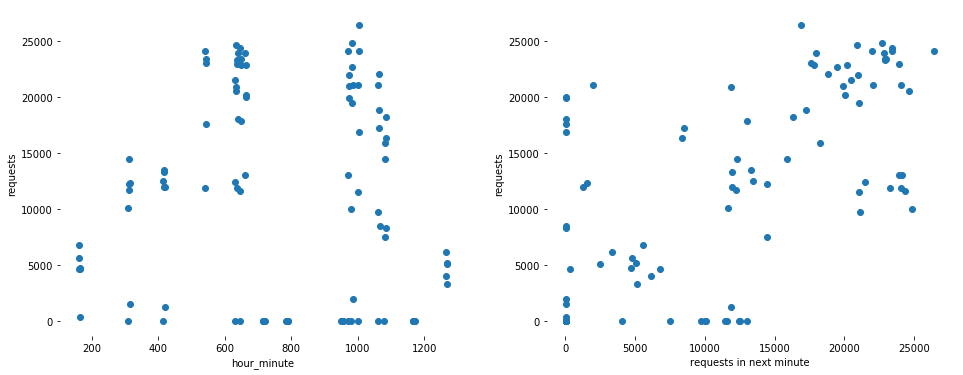

In [18]:
# Check correlation of load per min with load in next minute and time
corr_hour_min_count = pandas_df['count'].corr(pandas_df['hour_minute'])
corr_next_count_count = pandas_df['count'].corr(pandas_df['count_next'])
print('Correlation with time: ' "{0:.2f}".format(corr_hour_min_count))
print('Correlation with load in next minute: ' "{0:.2f}".format(corr_next_count_count))

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(pandas_df['hour_minute'], pandas_df['count'])
ax1.set_xlabel('hour_minute')
ax1.set_ylabel('requests')
for k, v in ax1.spines.items():
    v.set_visible(False)

ax2.scatter(pandas_df['count_next'], pandas_df['count'])
ax2.set_xlabel('requests in next minute')
ax2.set_ylabel('requests')
for k, v in ax2.spines.items():
    v.set_visible(False)
    
plt.show()

Coefficients: [ 0.6641999]
Intercept: 3340.77646067
MSE: 30789020.14
R2: 0.66


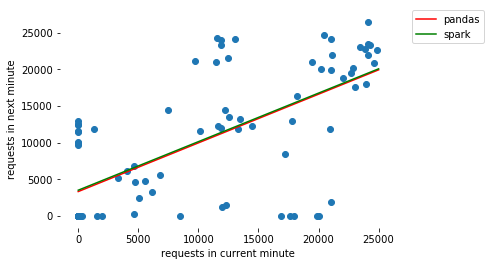

In [19]:
# Remove NaN from the DataFrame for regression model
pandas_df = pandas_df.loc[pd.notnull(pandas_df['count_next'])]

# Create linear regression object
regression = linear_model.LinearRegression()

X = np.transpose(np.array([pandas_df['count']]))
Y = np.transpose(np.array([pandas_df['count_next']]))

# Split the data into train test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

# Train the model
regression.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regression.predict(X_test)

# The coefficients
print("Coefficients: {0}".format(regression.coef_[0]))
print("Intercept: {0}".format(regression.intercept_[0]))

# The mean squared error
print('MSE: {0:.2f}'.format(mean_squared_error(Y_test, Y_pred)))
print('R2: {0:.2f}'.format(r2_score(Y_test, Y_pred)))

# For plotting linear regression model line
x1 = 0
x2 = 25000
y1 = regression.intercept_[0]
y2 = regression.coef_[0][0]*x2 + regression.intercept_[0]

# From mllib solution:
y1_dist = intercept_dist
y2_dist = coef_dist[0]*x2 + intercept_dist

# Plot fitted lines from the 2 solutions
fig, ax = plt.subplots()
ax.plot([x1, x2], [y1, y2], color = 'red', label = 'pandas')
ax.plot([x1, x2], [y1_dist, y2_dist], color = 'green', label = 'spark')
ax.scatter(X_train, Y_train)
ax.set_xlabel('requests in current minute')
ax.set_ylabel('requests in next minute')
for k, v in ax.spines.items():
    v.set_visible(False)

plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left', borderaxespad=0.)
plt.show()

# 2.2 Session length for a given IP
##### Session length for a given IP is a fixed quantity (I have not understood the predict part here). For a given IP, it can be estimated based on the average of all the session lengths or it can be estimated based on average of session lengths in a particular hour.

In [20]:
session_len_ip_wise = sessionized_df.select(['client_ip', 'hour', 'session_length'])
session_len_ip_wise = session_len_ip_wise.groupBy(['client_ip', 'hour']).agg(func.avg('session_length').alias('avg_session_time'))

# Printing result for an example IP
session_len_ip_wise.filter(session_len_ip_wise.client_ip == '178.255.153.2').show()

+-------------+----+----------------+
|    client_ip|hour|avg_session_time|
+-------------+----+----------------+
|178.255.153.2|  17|           181.0|
|178.255.153.2|  16|           389.5|
|178.255.153.2|  10|           854.0|
+-------------+----+----------------+



# 2.3 Number of unique URL visits by a given IP

##### Number of unique URLs visited by an IP is also a deterministic value. I may have misunderstood this problem, but computing this based on the data available

In [21]:
distinct_urls_df = log_df.groupBy(['client_ip']).agg(func.countDistinct('url').alias('distinct_urls'))
distinct_urls_df.show(10)

+---------------+-------------+
|      client_ip|distinct_urls|
+---------------+-------------+
|   27.63.186.72|            6|
|  14.139.82.134|          108|
| 117.241.152.20|           34|
| 113.193.114.25|           84|
|   120.61.47.36|            7|
| 117.207.97.173|            3|
|  202.53.89.132|          110|
|117.203.181.144|            2|
|  27.34.244.251|          112|
|123.136.182.137|           10|
+---------------+-------------+
only showing top 10 rows



In [22]:
spark.stop()